# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
using PyPlot, HDF5
using Statistics

El archivo adjunto **sacadatos.jl** contiene funciones para abrir y ordenar un archivo tipo *hdf5* del programa *Stimfit*.

In [2]:
include("sacadatos.jl")

devuelvedatos (generic function with 1 method)

In [5]:
nomine = "../h5files/180718_9.hf5"

"../h5files/180718_9.hf5"

In [6]:
datos = h5open(nomine, "r");
names(datos)

5-element Array{String,1}:
 "Im_primaryIm_sec"
 "Im_sec"          
 "channels"        
 "comment"         
 "description"     

In [7]:
constantes, sweps = devuelvedatos(datos, "Im_primaryIm_sec");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.04, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 25.0 kHz.


In [8]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const posG=round(Int, postGms*freq)

1000

Funciones auxiliares para convertir tiempo (en ms) a intervalos (en indices enteros) y viceversa:

In [9]:
function iart(i::Int,f::Int) 
  #  """function que pasa de intervalos enteros a tiempo en ms"""
aux=i:f
    result=aux./freq
end

function tari(it,ft)
    # funtion que pasa de tiempo en ms a intervalos enteros de indices
    auxi=round(Int, it*freq)
    auxf=round(Int, ft*freq)
    result=auxi:auxf
end

tari (generic function with 1 method)

Funciones de suavizado (duro y gaussiano), e.g. $ \tilde{x}= \sum_{-2}^{2} x_i /N$

In [10]:
function suaveduro(trazo::Array, nv=9)
# funcion que promedia cada punto sobre sus vecinos
    aux=trazo
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        result[j]=mean(aux[j:j+nv*2])
    end
    return result 
end


gauss(x, sigma)=exp(-(x/sigma)^2/2)

function pesosgauss(desv::Real,n::Int)
# funcion que promedia cada punto sobre sus vecinos, pero con peso gaussiano
    g=zeros(2*n+1)
    for j=-n:n
        g[j+n+1]=gauss(j,desv)
    end
    return g
end
        
function suavegauss(trazo::Array, nv=10)
    aux=trazo
    pesos=pesosgauss(nv/2,nv)
    pesoT=sum(pesos)
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        for k=0:2*nv
        result[j]+=aux[j+k]*pesos[k+1]
        end
    end
    result/=pesoT
    return result 
end

suavegauss (generic function with 2 methods)

La siguiente funcion, **intervalosP**, determina, a partir de la derivada suavizada de un trazo, los intervalos donde posiblemente hay una espiguleta o una espiga, es decir, aquellos cuya derivada es mayor a cierto umbral. 

In [138]:
function intervalosP(dtrazo::Array,thres=0.06, thres2=0.5)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo
    esunbrinco(x)=  x>thres 
    escontiguo(x,y)=(y-x)==1
    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    
    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        
    else 
        println("no hay naaaaaada en la seccion")
    end
    
    tamanointervalo=length(dtrazo)
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
     n=length(keys(preresult))
    if n>0    
    for j in keys(preresult)
        aux=preresult[j]
        (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
          #  println(aux)
        if a<thres2
            lugarreal=aux[lugarlista]
            ai=lugarreal-preG
            af=lugarreal+posG
            (ai<1) ? ai=1 : ai=ai
            (af>tamanointervalo) ? af=tamanointervalo : af=af
            (maximototal, b)=findmax(dtrazo[ai:af])  
            println("vamos bien, ", ai, " ", af, " ", maximototal)
         
            if maximototal<thres2
                result[j]=ai:af
            end
                
                end # Este cierra el a<thres2 .
        
    end
    
    else
       # println(" te dije que no hay naaaada")
    end
    
    return result
end

intervalosP (generic function with 3 methods)

In [74]:
g0(xs::Array ,d1=-71)= xs.-(xs[1]+d1) #funcion que normaliza al valor d1

g0 (generic function with 2 methods)

In [75]:
function average1(data::Dict)
    aux=0
    k=0
    for subs in keys(data)
        for j in keys(data[subs])
            rango=data[subs][j]
            valor=suaves[subs][rango]
            aux=aux.+valor
            k+=1
        end
    end
    result=aux./k
end

average1 (generic function with 1 method)

In [76]:
function separamochas(datos::Dict)
    
Limpias=Dict{String,Dict}()
Mochas=Dict{String,Dict}()
longi=preG+posG+1
    
    for subs in keys(datos)
    for j in keys(datos[subs])
        Limpias[subs]=Dict{Int, Array}()
        Mochas[subs]=Dict{Int, Array}()     
        if length(datos[subs][j])==longi
            Limpias[subs][j]=datos[subs][j]
        else
            Mochas[subs][j]=datos[subs][j]
        end
       
        if isempty(Limpias[subs])
            delete!(Limpias, subs)
        end
        
        if isempty(Mochas[subs])
            delete!(Mochas, subs)
        end
       
    end
end

result=(Limpias, Mochas)
end

separamochas (generic function with 1 method)

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [56]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [96]:
suaves=Dict{String, Array}()
difss=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    suaves[subs]=suavegauss(sweps[subs])
    difss[subs]=diff(suaves[subs])
    
end


In [97]:
difss

Dict{String,Array} with 59 entries:
  "section_57" => [0.000909861, 0.000574301, 9.73103e-5, -0.000500191, -0.00152…
  "section_44" => [-0.000701868, -0.000947423, -0.00122874, -0.00153111, -0.001…
  "section_06" => [-0.00160896, -0.00162842, -0.00152696, -0.00129563, -0.00094…
  "section_13" => [0.00210853, 0.00267192, 0.00297395, 0.00356787, 0.00357974, …
  "section_17" => [0.000497218, 0.000365853, -0.000147553, -0.000499569, -0.000…
  "section_56" => [-0.00383684, -0.00456326, -0.00525487, -0.00586164, -0.00633…
  "section_12" => [0.00120144, 0.00199093, 0.0023341, 0.00296215, 0.00395136, 0…
  "section_41" => [-0.00160896, -0.00162842, -0.00152696, -0.00129563, -0.00094…
  "section_16" => [0.00255638, 0.00251552, 0.0025585, 0.00276846, 0.00260395, 0…
  "section_09" => [0.000841205, 0.00120144, 0.00164929, 0.00217616, 0.00275985,…
  "section_58" => [-0.00153111, -0.0021747, -0.0026081, -0.00303215, -0.0034218…
  "section_07" => [0.00162842, 0.00152696, 0.00129563, 0.000943275, 0.000

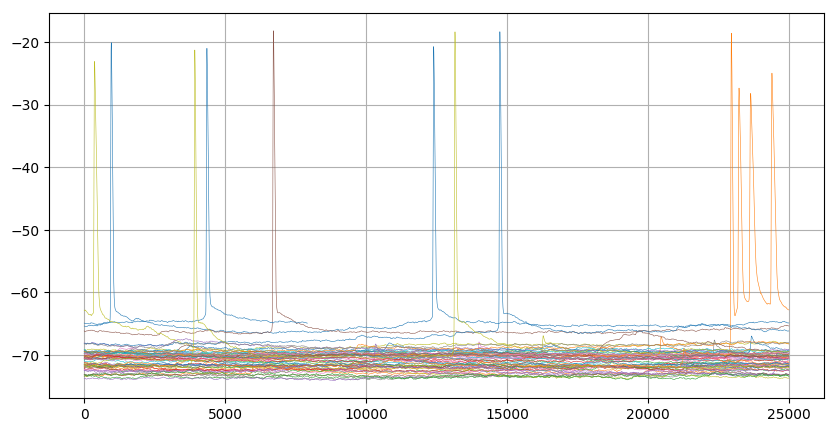

In [98]:
figura=figure(figsize=(10,5))
for subs in keys(suaves)
 plot(suaves[subs], label=subs, lw=0.4)
end
#legend()
grid()

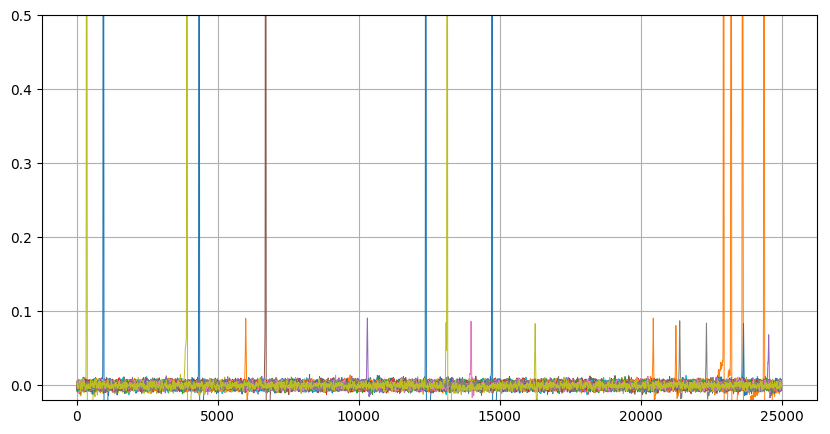

In [99]:
figura=figure(figsize=(10,5))
ylim(-0.02, 0.5)
for subs in keys(difss)
 plot(difss[subs], label=subs, lw=0.7)
end
#legend()
grid()

In [139]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(difss)
    println(subs)
 intSS[subs]=intervalosP(difss[subs], 0.06, 0.4)
end

section_57
section_44
vamos bien, 5738 6988 0.09080533205231234
section_06
no hay naaaaaada en la seccion
section_13
no hay naaaaaada en la seccion
section_17
no hay naaaaaada en la seccion
section_56
section_12
no hay naaaaaada en la seccion
section_41
vamos bien, 21138 22388 0.08739537561231714
section_16
vamos bien, 16009 17259 0.08366129987334148
section_09
no hay naaaaaada en la seccion
section_58
section_07
no hay naaaaaada en la seccion
section_43
no hay naaaaaada en la seccion
section_29
no hay naaaaaada en la seccion
section_39
no hay naaaaaada en la seccion
section_40
no hay naaaaaada en la seccion
section_10
no hay naaaaaada en la seccion
section_04
no hay naaaaaada en la seccion
section_45
section_00
no hay naaaaaada en la seccion
section_32
no hay naaaaaada en la seccion
section_36
no hay naaaaaada en la seccion
section_47
no hay naaaaaada en la seccion
section_49
no hay naaaaaada en la seccion
section_46
vamos bien, 24294 24999 0.06853030502435331
section_03
no hay naaaaa

In [140]:
intSS

Dict{String,Dict} with 59 entries:
  "section_57" => Dict{Int64,Any}()
  "section_44" => Dict{Int64,Any}(1=>5738:6988)
  "section_06" => Dict{Int64,Any}()
  "section_13" => Dict{Int64,Any}()
  "section_17" => Dict{Int64,Any}()
  "section_56" => Dict{Int64,Any}()
  "section_12" => Dict{Int64,Any}()
  "section_41" => Dict{Int64,Any}(1=>21138:22388)
  "section_16" => Dict{Int64,Any}(1=>16009:17259)
  "section_09" => Dict{Int64,Any}()
  "section_58" => Dict{Int64,Any}()
  "section_07" => Dict{Int64,Any}()
  "section_43" => Dict{Int64,Any}()
  "section_29" => Dict{Int64,Any}()
  "section_39" => Dict{Int64,Any}()
  "section_40" => Dict{Int64,Any}()
  "section_10" => Dict{Int64,Any}()
  "section_04" => Dict{Int64,Any}()
  "section_45" => Dict{Int64,Any}()
  "section_00" => Dict{Int64,Any}()
  "section_32" => Dict{Int64,Any}()
  "section_36" => Dict{Int64,Any}()
  "section_47" => Dict{Int64,Any}()
  "section_49" => Dict{Int64,Any}()
  "section_46" => Dict{Int64,Any}(1=>24294:24999)
  ⋮        

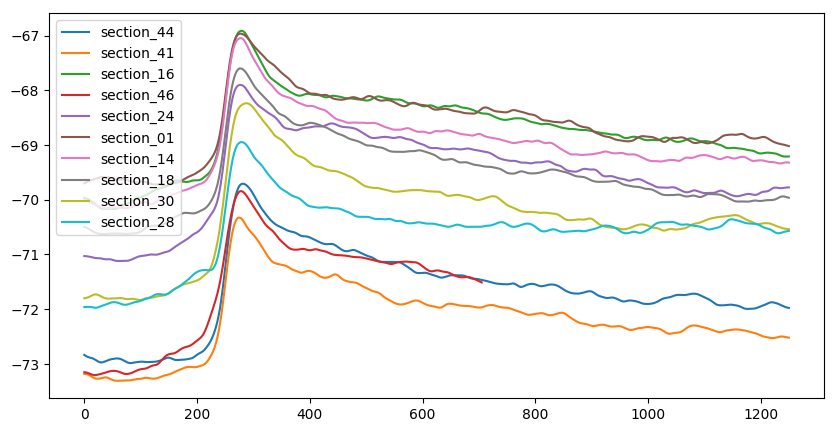

PyObject <matplotlib.legend.Legend object at 0x7f1778a984e0>

In [141]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        plot(suaves[subs][rango], label=subs)
    end
end

legend()

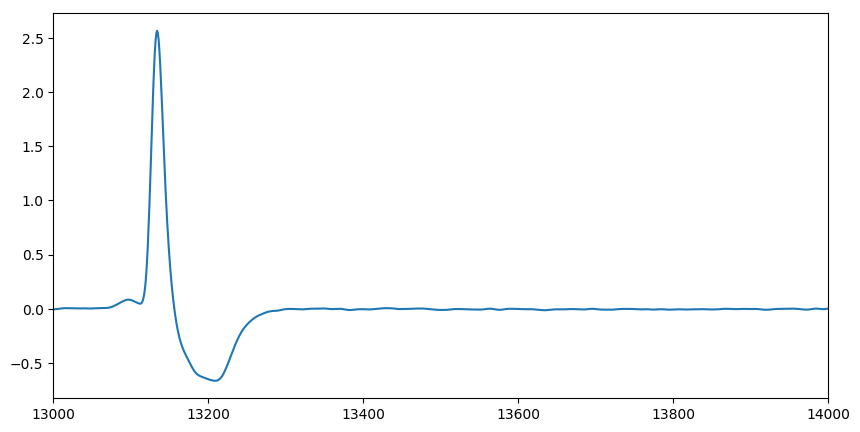

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1778baa278>

In [142]:
figura=figure(figsize=(10,5))
xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(difss["section_50"])
#plot(suaves["section_50"])

In [143]:
(limpia, mocha)=separamochas(intSS);

In [144]:
a=average1(limpia);

In [145]:
normCut=Dict{String,Dict}()
    
for subs in keys(limpia)
    normCut[subs]=Dict{Int, Array}()
    for j in keys(limpia[subs])
         arre=intSS[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
    end
end

In [146]:
normCut

Dict{String,Dict} with 9 entries:
  "section_16" => Dict{Int64,Array}(1=>[-71.2207, -71.2221, -71.2242, -71.227, …
  "section_18" => Dict{Int64,Array}(1=>[-71.2207, -71.2223, -71.2251, -71.2289,…
  "section_44" => Dict{Int64,Array}(1=>[-71.2207, -71.2278, -71.2344, -71.2407,…
  "section_14" => Dict{Int64,Array}(1=>[-71.2207, -71.2212, -71.2223, -71.2242,…
  "section_24" => Dict{Int64,Array}(1=>[-71.2207, -71.2212, -71.2217, -71.2226,…
  "section_30" => Dict{Int64,Array}(1=>[-71.2207, -71.2197, -71.2182, -71.2162,…
  "section_28" => Dict{Int64,Array}(1=>[-71.2207, -71.22, -71.2192, -71.2187, -…
  "section_01" => Dict{Int64,Array}(1=>[-71.2207, -71.2157, -71.2107, -71.2055,…
  "section_41" => Dict{Int64,Array}(1=>[-71.2207, -71.2215, -71.2229, -71.2245,…

In [87]:
mocha

Dict{String,Dict} with 1 entry:
  "section_46" => Dict{Int64,Array}(1=>[24294, 24295, 24296, 24297, 24298, 2429…

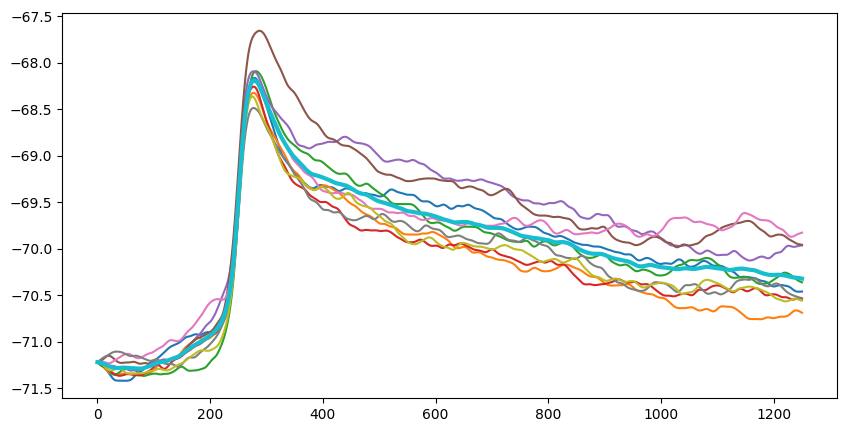

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f177872f1d0>

In [147]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normCut)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normCut[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(normCut[subs][j])
    end
end

plot(a, lw=3)

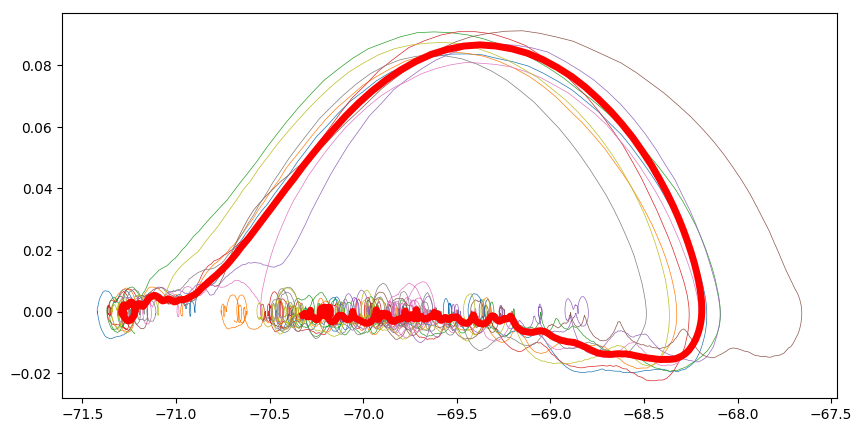

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1778ff0a90>

In [148]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), difss[subs][rango], lw=0.5)
    end
end
plot(promSpK[2:end],difProm, lw=5, c="red")

Dict{String,Dict} with 9 entries:
  "section_16" => Dict{Int64,Array}(1=>[16009, 16010, 16011, 16012, 16013, 1601…
  "section_18" => Dict{Int64,Array}(1=>[22085, 22086, 22087, 22088, 22089, 2209…
  "section_44" => Dict{Int64,Array}(1=>[5738, 5739, 5740, 5741, 5742, 5743, 574…
  "section_14" => Dict{Int64,Array}(1=>[20198, 20199, 20200, 20201, 20202, 2020…
  "section_24" => Dict{Int64,Array}(1=>[13733, 13734, 13735, 13736, 13737, 1373…
  "section_30" => Dict{Int64,Array}(1=>[10055, 10056, 10057, 10058, 10059, 1006…
  "section_28" => Dict{Int64,Array}(1=>[21001, 21002, 21003, 21004, 21005, 2100…
  "section_01" => Dict{Int64,Array}(1=>[23400, 23401, 23402, 23403, 23404, 2340…
  "section_41" => Dict{Int64,Array}(1=>[21138, 21139, 21140, 21141, 21142, 2114…

In [37]:
Mochas

Dict{String,Dict} with 1 entry:
  "section_46" => Dict{Int64,Array}(1=>[24294, 24295, 24296, 24297, 24298, 2429…

In [149]:
promSpK=a

1251-element Array{Float64,1}:
 -71.22069968142677
 -71.22129282387594
 -71.22209153703982
 -71.2231199895337 
 -71.22439605041667
 -71.22582338074727
 -71.22749320162285
 -71.22931491781091
 -71.23127771911032
 -71.23342623906882
 -71.23569148850405
 -71.23815887949615
 -71.24073281908507
   ⋮               
 -70.31243797764436
 -70.3130449295794 
 -70.31365971486032
 -70.3143674435385 
 -70.31507725549407
 -70.31590630172214
 -70.31678655523059
 -70.31782492953339
 -70.31888301762882
 -70.32005924124897
 -70.32115566774888
 -70.3222758454625 

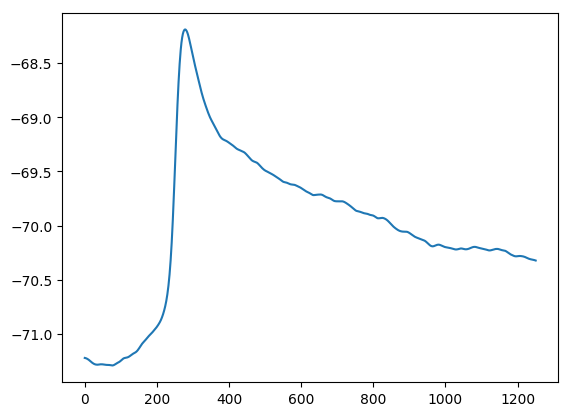

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f17789ebf28>

In [150]:
plot(promSpK)

In [151]:
difProm=diff(promSpK)

1250-element Array{Float64,1}:
 -0.0005931424491762982
 -0.000798713163874254 
 -0.0010284524938839468
 -0.0012760608829722742
 -0.0014273303305998297
 -0.0016698208755769883
 -0.001821716188061373 
 -0.001962801299413286 
 -0.0021485199584958536
 -0.002265249435225769 
 -0.002467390992109131 
 -0.0025739395889132766
 -0.002644449290613693 
  ⋮                    
 -0.0006422019717859939
 -0.0006069519350404562
 -0.0006147852809164078
 -0.0007077286781793646
 -0.0007098119555735138
 -0.0008290462280626798
 -0.000880253508455553 
 -0.0010383743027944092
 -0.001058088095433618 
 -0.0011762236201491305
 -0.0010964264999131501
 -0.0011201777136164992

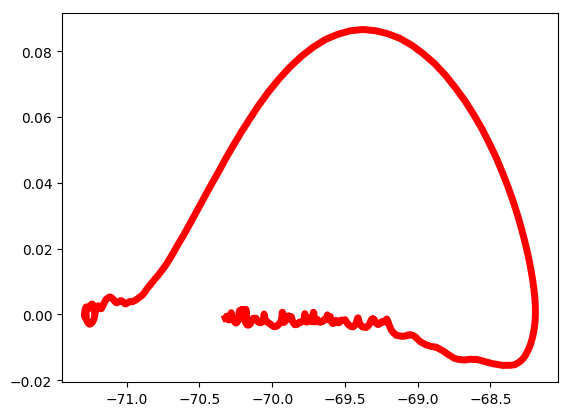

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1778655978>

In [154]:
plot(promSpK[2:end],difProm, lw=5, c="red")